In [1]:
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
import datetime
import numpy as np
import statsmodels.api as sm
import math
import glob, os
from PIL import Image

In [2]:
url = "https://cog-uk.s3.climb.ac.uk/phylogenetics/latest/cog_metadata.csv"
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))
print(df.shape)
#(179931, 18)

(242925, 19)


In [3]:
df

,sequence_name,country,adm1,pillar_2,sample_date,epi_week,lineage,lineage_support,d614g,n439k,p323l,a222v,y453f,e484k,n501y,t1001i,p681h,q27stop,del_21765_6
0,England/NOTT-24D16C/2021,UK,UK-ENG,False,2021-02-02,58,B.1.1.7,1.0,G,N,L,A,Y,E,Y,I,H,*,del
1,England/NOTT-24D1A8/2021,UK,UK-ENG,False,2021-02-02,58,B.1.1.7,1.0,G,N,L,A,Y,E,Y,I,H,*,del
2,England/NOTT-24D0F6/2021,UK,UK-ENG,False,2021-02-01,58,B.1.177.4,1.0,G,N,L,V,Y,E,N,T,P,Q,ref
3,England/NOTT-24D59D/2021,UK,UK-ENG,False,2021-02-02,58,B.1.1.7,1.0,G,N,L,A,Y,E,Y,I,H,*,del
4,England/NOTT-24D58E/2021,UK,UK-ENG,False,2021-02-02,58,B.1.1.7,1.0,G,N,L,A,Y,E,Y,I,H,*,del
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242920,Scotland/CVR04/2020,UK,UK-SCT,False,2020-03-04,10,B.11,1.0,D,X,P,A,X,X,X,T,P,Q,ref
242921,Scotland/CVR05/2020,UK,UK-SCT,False,2020-03-04,10,B.1,1.0,G,N,L,A,Y,E,N,T,P,Q,ref
242922,Scotland/CVR03/2020,UK,UK-SCT,False,2020-03-01,10,B.1,1.0,G,X,L,A,X,X,X,T,P,Q,ref
242923,Scotland/CVR02/2020,UK,UK-SCT,False,2020-03-02,10,B.11,1.0,D,X,P,A,X,X,X,T,P,Q,ref


In [4]:
# tables from https://github.com/russss/covidtracker/commit/b9c6a9cbd8c7ae048b24eb8f7bbd482ae84ee2e3 
labs = {
    "PORT": "Portsmouth",
    "LOND": "London",  # UCL/Imperial
    "NORT": "Newcastle",  # University of Northumbria
    "EXET": "Exeter",  # University of Exeter
    "NORW": "Norwich",  # Quadram Institute Bioscience
    "MILK": "Milton Keynes",  # Lighthouse Lab Milton Keynes (Wellcome Sanger Institute)
    "ALDP": "Alderley Park",  # Lighthouse
    "QEUH": "Glasgow",  # Glasgow
    "BIRM": "Birmingham",  # University of Birmingham
    "BHRT": "London",  # Barking, Havering, Redbridge trust
    "PHEC": "London",  # PHE Colindale
    "CAMC": "Cambridge",  # Cambridge lighthouse lab,
    "WSFT": "Chichester",  # Western Sussex Foundation Trust
    "LIVE": "Liverpool",  # Liverpool Clinical Laboratories
    "NOTT": "Nottingham",  # DeepSeq Nottingham
    "LCST": "Nottingham",  # Seems to be nottingham but what does LCST stand for?
    "SHEF": "Sheffield",  # University of Sheffield
    "CAMB": "Cambridge",  # University of Cambridge
    "BRIS": "Bristol",
    "EKHU": "Ashford",
    "HECH": "Hereford",
    "KGHT": "Kettering",  # Kettering general hospital trust (presumed)
    "OXON": "Oxford",
    "LEED": "Leeds",
    "TBSD": "Torbay",  # The Department of Microbiology, Torbay and South Devon NHS Foundation Trust
    "GSTT": "London",  # Guys and St Thomas',
    "PHWC": "Cardiff",  # PHW Cardiff (presumably)
    "GCVR": "Glasgow",  # MRC-University of Glasgow Centre for Virus Research
    "EDB": "Edinburgh",
    "CVR": "Glasgow",
    "QEU": "Glasgow",
    "NIRE": "Northern Ireland",
    "TFCI": "London",  # The Francis Crick Institute
    "CWAR": "Warwick",  # Coventry and Warwick something something
    "MTUN": "Maidstone",  # Maidstone and Tunbridge Wells
    "PRIN": "Harlow",  # Princess Alexandra Hospital
}
lab_regions = {
    "Alderley Park": "North West",
    "Ashford": "South East",
    "Birmingham": "Midlands",
    "Bristol": "South West",
    "Cambridge": "East of England",
    "Cardiff": "Wales",
    "Chichester": "South East",
    "Edinburgh": "Scotland",
    "Exeter": "South West",
    "Glasgow": "Scotland",
    "Harlow": "East of England",
    "Hereford": "Midlands",
    "Kettering": "Midlands",
    "Leeds": "North East and Yorkshire",
    "Liverpool": "North West",
    "London": "London",
    "Maidstone": "South East",
    "Milton Keynes": "East of England",
    "Newcastle": "North East and Yorkshire",
    "Northern Ireland": "Northern Ireland",
    "Norwich": "East of England",
    "Nottingham": "Midlands",
    "Oxford": "South East",
    "Portsmouth": "South East",
    "Sheffield": "North East and Yorkshire",
    "Torbay": "South West",
    "Warwick": "Midlands",
}

df['lab'] = df.apply(lambda row: row['sequence_name'].split("/")[1].split("-")[0], axis=1)
df['lab_region'] = df.apply(lambda row: lab_regions[labs[row['lab']]] if row['lab'] in labs.keys() else 'Other', axis=1)

nhsRegions = set(df['lab_region'].to_list())
print(nhsRegions)

{'South East', 'Scotland', 'Northern Ireland', 'Wales', 'North East and Yorkshire', 'North West', 'South West', 'East of England', 'London', 'Other', 'Midlands'}


In [5]:
df

,sequence_name,country,adm1,pillar_2,sample_date,epi_week,lineage,lineage_support,d614g,n439k,...,a222v,y453f,e484k,n501y,t1001i,p681h,q27stop,del_21765_6,lab,lab_region
0,England/NOTT-24D16C/2021,UK,UK-ENG,False,2021-02-02,58,B.1.1.7,1.0,G,N,...,A,Y,E,Y,I,H,*,del,NOTT,Midlands
1,England/NOTT-24D1A8/2021,UK,UK-ENG,False,2021-02-02,58,B.1.1.7,1.0,G,N,...,A,Y,E,Y,I,H,*,del,NOTT,Midlands
2,England/NOTT-24D0F6/2021,UK,UK-ENG,False,2021-02-01,58,B.1.177.4,1.0,G,N,...,V,Y,E,N,T,P,Q,ref,NOTT,Midlands
3,England/NOTT-24D59D/2021,UK,UK-ENG,False,2021-02-02,58,B.1.1.7,1.0,G,N,...,A,Y,E,Y,I,H,*,del,NOTT,Midlands
4,England/NOTT-24D58E/2021,UK,UK-ENG,False,2021-02-02,58,B.1.1.7,1.0,G,N,...,A,Y,E,Y,I,H,*,del,NOTT,Midlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242920,Scotland/CVR04/2020,UK,UK-SCT,False,2020-03-04,10,B.11,1.0,D,X,...,A,X,X,X,T,P,Q,ref,CVR04,Other
242921,Scotland/CVR05/2020,UK,UK-SCT,False,2020-03-04,10,B.1,1.0,G,N,...,A,Y,E,N,T,P,Q,ref,CVR05,Other
242922,Scotland/CVR03/2020,UK,UK-SCT,False,2020-03-01,10,B.1,1.0,G,X,...,A,X,X,X,T,P,Q,ref,CVR03,Other
242923,Scotland/CVR02/2020,UK,UK-SCT,False,2020-03-02,10,B.11,1.0,D,X,...,A,X,X,X,T,P,Q,ref,CVR02,Other


In [23]:
def add_inferred_exponential(ax, x, y, m=None):
    _x = np.linspace(1,len(y),len(y)).reshape(-1,1)
    _y = [y_val if y_val>0 else np.nan for y_val in y]
    log_y = np.log(_y)
    _xsm = sm.add_constant(_x)
    results = sm.OLS(log_y,_xsm, missing="drop").fit()
    b,a = results.params
    r = results.rsquared
    y_pred = [math.exp(a*i+b) for i in _x]
    d = math.log(2) / a
    if ax:
        xlabel = "doubling time = %.1f days \n r_squared (log_y) = %0.2f" % (d, r)
        ax.plot(x, y_pred, color="blue", label="fitted to exponential growth")
        ax.set_xlabel(xlabel)
    return a,b,d

def add_inferred_sigmoid(ax, x, y, m=None):
    _x = np.linspace(1,len(y),len(y)).reshape(-1,1)
    _y = [math.log(p/(1-p)) if (p>0 and p<1) else np.nan for p in y]
    _xsm = sm.add_constant(_x)
    results = sm.OLS(_y,_xsm, missing="drop").fit()
    b,a = results.params
    r = results.rsquared
    y_pred = [math.exp(a*i+b)/(1+math.exp(a*i+b)) for i in _x]
    w = math.exp(7*a)-1
    if ax:
        xlabel = "sigmoid initial weekly growth = %.0f%% \n sigmoid y-intercept = %.1f \n r_squared (logit_y) = %0.2f" % (100*w, b, r)
        ax.plot(x, y_pred, color="blue", label="fitted to sigmoid curve")
        ax.set_xlabel(xlabel)
    return a,b

def make_graph(df, start_date, end_date, title):
    y_samples = []
    y_prevalence = [] 
    x = []

    start = datetime.datetime.strptime(start_date,"%Y-%m-%d")
    end = datetime.datetime.strptime(end_date,"%Y-%m-%d")
    dates = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
    
    for date in dates:
        week_end = date.strftime("%Y-%m-%d")
        week_start = (date - datetime.timedelta(days=7)).strftime("%Y-%m-%d")
        _df = df[(df.sample_date>week_start) & (df.sample_date<=week_end)] # weekly avg changes initial const but not rate of growth
        #_df = df[df.sample_date==week_end]
        x.append(date)
        t = _df.shape[0] /7
        n = _df[_df.lineage=="B.1.1.7"].shape[0] /7
        p = n / t if t>0 else 0
        y_samples.append(t)
        y_prevalence.append(p if (p>0.1 and t>500) else np.nan)
            
            
    x, y_samples, y_prevalence = zip(*sorted(zip(x, y_samples, y_prevalence)))
    
    if np.count_nonzero(~np.isnan(y_prevalence))==0:
        print(nhsRegion, "no data")
        return
    
    plt.clf()
    fig, ax1 = plt.subplots(1,1, figsize=(8,6))
    ax2 = ax1.twinx()

    ax2.plot(x, y_samples, color="green", label="total samples", alpha=0.25)
    ax1.plot(x, y_prevalence, color="red", label="B.1.1.7 samples (7 day avg)")# (7 day avg)")

    add_inferred_sigmoid(ax1, x, y_prevalence)
    #add_inferred_exponential(ax1, x, y_prevalence)

    ax1.legend(loc="upper left")
    ax2.legend(loc="center left")
    ax1.set_ylabel("B.1.1.7 as propn of total")
    #ax1.set_ylabel("B.1.1.7 samples as propn of total, log(p/(1-p))")
    ax1.xaxis.set_major_locator(MultipleLocator(14)) 
    ax2.set_ylabel("total samples")
    ax2.set_ylim(0,None)
    ax1.set_ylim(0,None)
    
    fig.suptitle(title)

    plt.savefig("B117_%s.png" % title)
    #plt.savefig("1.png")
    plt.show()



<Figure size 432x288 with 0 Axes>

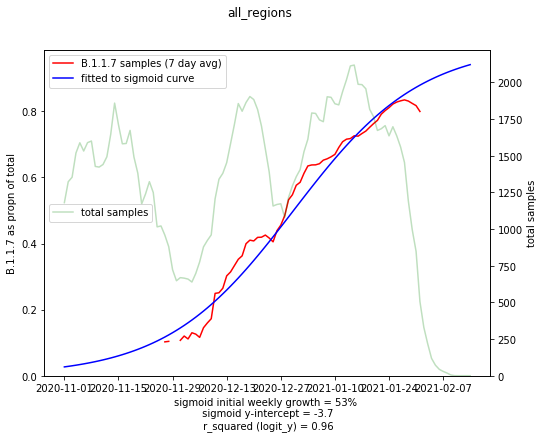

In [24]:
start_date = "2020-11-01"
end_date = "2021-02-15"

make_graph(df, start_date, end_date, "all_regions")

South East no data
Scotland no data
Northern Ireland no data
Wales no data
North East and Yorkshire no data


<Figure size 432x288 with 0 Axes>

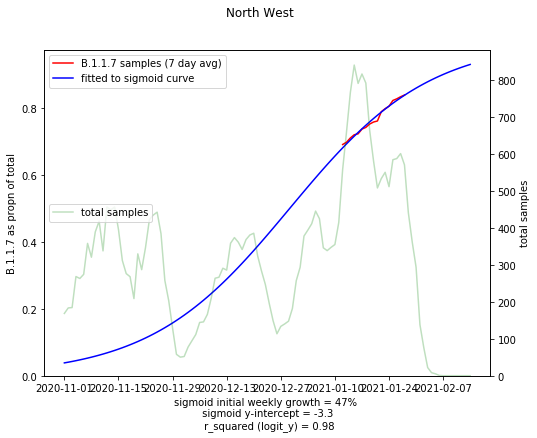

South West no data


<Figure size 432x288 with 0 Axes>

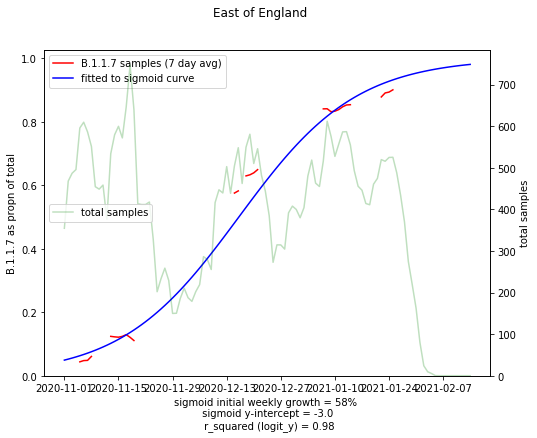

London no data
Other no data
Midlands no data


In [8]:
for nhsRegion in nhsRegions:
    if nhsRegion=="other":
        continue
    _df = df[df.lab_region==nhsRegion]
    make_graph(_df, start_date, end_date, nhsRegion)
    
    

In [9]:
def get_concat_v(image_list):
    h = 0
    for im in image_list:
        h += im.height
    dst = Image.new('RGB', (image_list[0].width, h))
    dst.paste( (255,255,255), [0,0,dst.size[0],dst.size[1]])    
    h = 0
    for im in image_list:
        dst.paste(im, (0, h))
        h += im.height
    return dst

image_paths = glob.glob("./*.png")
images = []
print(image_paths)
for im_path in image_paths:
    if "concat" in im_path:
        continue
    images.append(Image.open(im_path))
dst = get_concat_v(images)
dst.save(os.path.join(".", "concat.png"))


['./1.png', './2.png', './B117_all_regions.png', './B117_East of England.png', './B117_London.png', './B117_Midlands.png', './B117_North East and Yorkshire.png', './B117_North West.png', './B117_Other.png', './B117_Scotland.png', './B117_South East.png', './B117_South West.png', './B117_Wales.png', './concat.png']
